<a href="https://colab.research.google.com/github/BehdadSDP/pc_03_CNN/blob/main/pc_cnn_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -rf /content/sample_data

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

download dataset from kaggle to colab

In [ ]:
! pip install -q kaggle #install kaggle

In [ ]:
from google.colab import files

! mkdir ~/.kaggle #make directory
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/ #copy token file
! chmod 600 ~/.kaggle/kaggle.json #give premision

In [ ]:
! kaggle datasets download -d saraparsaseresht/persian-traffic-sign-dataset-ptsd  #download dataset

In [ ]:
!unzip /content/persian-traffic-sign-dataset-ptsd.zip -d ./persian_traffic_sign

Streaming output truncated to the last 5000 lines.
  inflating: ./persian_traffic_sign/PTSD_Recognition/PTSD_Recognition/train/31_Roundabouts/31_00289.jpg  
  inflating: ./persian_traffic_sign/PTSD_Recognition/PTSD_Recognition/train/31_Roundabouts/31_00290.jpg  
  inflating: ./persian_traffic_sign/PTSD_Recognition/PTSD_Recognition/train/31_Roundabouts/31_00291.jpg  
  inflating: ./persian_traffic_sign/PTSD_Recognition/PTSD_Recognition/train/31_Roundabouts/31_00292.jpg  
  inflating: ./persian_traffic_sign/PTSD_Recognition/PTSD_Recognition/train/31_Roundabouts/31_00293.jpg  
  inflating: ./persian_traffic_sign/PTSD_Recognition/PTSD_Recognition/train/31_Roundabouts/31_00294.jpg  
  inflating: ./persian_traffic_sign/PTSD_Recognition/PTSD_Recognition/train/31_Roundabouts/31_00295.jpg  
  inflating: ./persian_traffic_sign/PTSD_Recognition/PTSD_Recognition/train/31_Roundabouts/31_00296.jpg  
  inflating: ./persian_traffic_sign/PTSD_Recognition/PTSD_Recognition/train/31_Roundabouts/31_00297.j

In [ ]:
!rm -rf /content/persian-traffic-sign-dataset-ptsd.zip
!rm -rf /content/persian_traffic_sign/testset_CSV.csv

change the excel file

In [ ]:
!cp /content/drive/MyDrive/testset_CSV.csv /content/persian_traffic_sign #move the correct file

organize the datsaets

In [ ]:
import os
import shutil

path = "/content/persian_traffic_sign/PTSD_Recognition/PTSD_Recognition/train"
classes = [0, 1, 2, 3 , 4, 5, 6, 7, 8, 9]

for i in os.listdir(path):
  if int((os.path.join(path, i).split("/")[6]).split("_")[0]) in classes:
    continue
  else:
    shutil.rmtree(os.path.join(path, i))

In [ ]:
import torch
from torchvision import datasets, transforms
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader, random_split
import copy

data_dir = r"/content/persian_traffic_sign/PTSD_Recognition/PTSD_Recognition/train"
dataset = datasets.ImageFolder(data_dir)

mean = [0.5, 0.5, 0.5] #use image net mean
std = [0.5, 0.5, 0.5]  #use image net std
train_transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize(mean, std),
    #  transforms.RandomHorizontalFlip(),
    #  transforms.GaussianBlur(kernel_size= 3, sigma=(0.1, 0.2)),
    #  transforms.ColorJitter(contrast=0.01),
     transforms.Resize((100, 100))
])

val_transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize(mean, std),
     transforms.Resize((100, 100))
])

#split train folder to train and validation(0.8 train and 0.2 val)
train_r = 0.8 #train ratio
val_r = 0.2 #val ratio
train_size = int(train_r * len(dataset)) + 1  #train set size
val_size = int(val_r * len(dataset))  #val set size
torch.manual_seed(10)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size]) #split data to train set and val set
train_dataset = copy.deepcopy(train_dataset)
val_dataset = copy.deepcopy(val_dataset)
# Apply the respective transformations to the training and validation sets
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

In [ ]:
labels_map ={
    0: "Compulsory Keep BothSide",
    1: "Compulsory Keep Left",
    2: "Compulsory Keep Right",
    3: "Cycle crossing",
    4: "Danger",
    5: "Give Way",
    6: "Hump",
    7: "Left Bend",
    8: "Left Margin",
    9: "Left Turn Prohibited"
}

In [ ]:
# #get the average hieght and weight
# heights = 0
# weights = 0
# for image in range(len(X_train)):
#    _, height, weight = X_train[image].size()
#    heights += height
#    weights += weight

# av_height = heights/len(X_train)
# av_weight = weights/len(X_train)

show random image

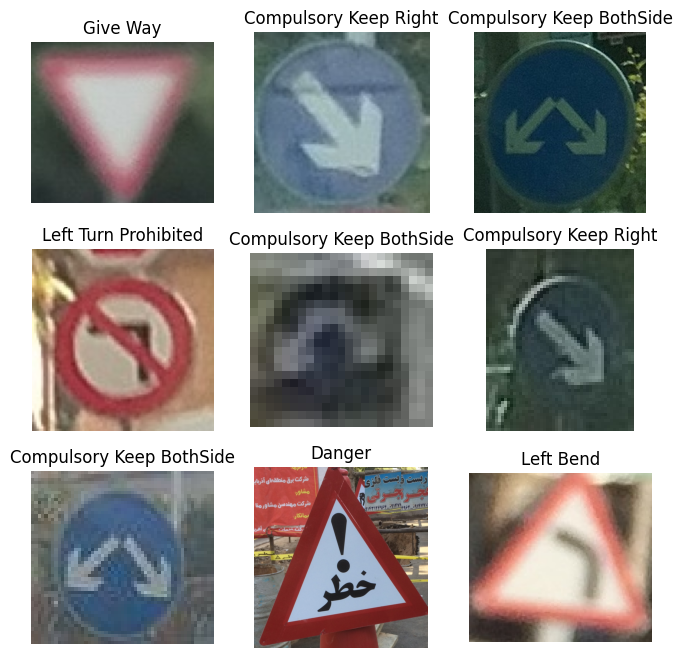

In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

transform = transforms.ToTensor()  # Transformation to convert the image to a tensor

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    index = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[index]
    img_tensor = transform(img)  # Convert img to a PyTorch tensor
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img_tensor.permute(1, 2, 0))
plt.show()

Model

In [ ]:
import torch
from torch.utils.data import DataLoader

#check for GPU available
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

#train loader
B = 4  #batch size
trainloader = DataLoader(train_dataset, batch_size= B, shuffle= True)
valloader = DataLoader(val_dataset, batch_size= B, shuffle = True)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.init as init

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        D = 100 * 100  # image res
        C = 3  # image channel
        k = 3  # filter size
        filters = 24
        # self.conv_layers = nn.Sequential(
        #     nn.Conv2d(3, 64, kernel_size=K, padding=K // 2, stride=1),  # the dimension of input image is: 200 * 200
        #     nn.BatchNorm2d(64),
        #     nn.ReLU(),
        #     nn.Conv2d(64, 64, kernel_size=K, padding=K // 2, stride=1),
        #     nn.BatchNorm2d(64),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2),  # the dimension of input image is: 100 * 100
        #     nn.Conv2d(64, 128, kernel_size=K, padding=K // 2, stride=1),
        #     nn.BatchNorm2d(128),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2),  # the dimension of input image is: 50 * 50
        #     nn.Conv2d(128, 512, kernel_size=K, padding=K // 2, stride=1),
        #     nn.BatchNorm2d(512),
        #     nn.ReLU(),
        #     nn.Conv2d(512, 512, kernel_size=K, padding=K // 2, stride=1),
        #     nn.BatchNorm2d(512),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2)  # the dimension of input image is: 25 * 25
        # )

        # self.fc_layer = nn.Sequential(
        #     nn.Linear(512 * 25 * 25, 128),
        #     nn.BatchNorm1d(128),
        #     nn.ReLU(),
        #     # nn.Dropout(0.5),  # Adding dropout with a probability of 0.5
        #     nn.Linear(128, 64),
        #     nn.BatchNorm1d(64),
        #     nn.ReLU(),
        #     # nn.Dropout(0.5),  # Adding dropout with a probability of 0.5
        #     nn.Linear(64, num_classes)
        # )
        self.conv_layers = nn.Sequential(
          nn.Conv2d(C, filters, k, padding=k//2),
          nn.Tanh(),
          nn.Conv2d(filters, filters, k, padding=k//2),
          nn.Tanh(),
          nn.Conv2d(filters, filters, k, padding=k//2),
          nn.Tanh(),
          nn.MaxPool2d(2),
          nn.Conv2d(filters, 2*filters, k, padding=k//2),
          nn.Tanh(),
          nn.Conv2d(2*filters, 2*filters, k, padding=k//2),
          nn.Tanh(),
          nn.Conv2d(2*filters, 2*filters, k, padding=k//2),
          nn.Tanh(),
          nn.MaxPool2d(2),
        )

        self.fc_layer = nn.Sequential(
          nn.Linear(2*filters * D * D, num_classes)
        )


        for module in self.conv_layers:
            if isinstance(module, nn.Conv2d):
                init.xavier_uniform_(module.weight)

    # def forward(self, x):
    #     x = self.conv_layers(x)
    #     x = x.view(x.size(0), -1)
    #     x = self.fc_layer(x)
    #     return x

In [ ]:
model = CNN(10)

In [ ]:
 _ = model.to(device)

In [ ]:
def accuracy(y_pred, y):

    pred_idx = y_pred.max(1, keepdim=True)[1]
    correct = pred_idx.eq(y.view_as(pred_idx)).sum().item()
    return correct / len(y)

In [ ]:
from tensorflow import summary
from torch.utils.tensorboard import SummaryWriter

%load_ext tensorboard
%tensorboard --logdir runs

writer = SummaryWriter('runs/train_base_model')

In [ ]:
def train(model, optimizer, epoch, check_point):

  running_loss = 0
  running_acc = 0

  model.train()

  for idx, (X, y) in enumerate(tqdm(trainloader)):
      optimizer.zero_grad()
      X, y = X.to(device), y.to(device)
      y_hat = model(X)
      loss = criterion(y_hat, y)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      running_acc += accuracy(y_hat, y)
      lr=optimizer.param_groups[0]["lr"]

  running_loss = running_loss/ len(trainloader)
  running_acc = running_acc / len(trainloader)
  hty_train['train_loss'].append(running_loss)
  hty_train['train_acc'].append(running_acc)
  print(f'Epoch {epoch}/{n_epochs} : training loss: {round(running_loss,3)}, training acc: {round(running_acc*100,2)}')
  lrs.append(lr)

  #tensor board
  writer.add_scalar('Loss/train', running_loss, epoch)
  writer.add_scalar('Accuracy/train', running_acc, epoch)
  if(epoch == n_epochs):
    if check_point is not None:
      torch.save({
      'epoch': epoch,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'training_loss': running_loss,
      }, "/content/train_ck.pt")

In [ ]:
def validation(model, epoch):

  val_running_loss = 0
  val_running_acc = 0

  model.eval()

  with torch.no_grad():
      for idx, (X, y) in enumerate(tqdm(valloader)):
          X, y = X.to(device), y.to(device)
          y_hat = model(X)
          loss = criterion(y_hat, y)

          val_running_loss += loss.item()
          val_running_acc += accuracy(y_hat, y)
      else:
          val_running_loss = val_running_loss/ len(valloader)
          val_running_acc = val_running_acc / len(valloader)
          hty_val['val_loss'].append(val_running_loss)
          hty_val['val_acc'].append(val_running_acc)
          print(f'Epoch {epoch}/{n_epochs} : validation loss: {round(val_running_loss,3)}, validation acc: {round(val_running_acc*100,2)}')

  writer.add_scalar('Accuracy/val',  val_running_acc, epoch)
  writer.add_scalar('Loss/val', val_running_loss, epoch)



In [ ]:
from torch.utils.tensorboard import SummaryWriter
from torch import  optim
from tqdm import tqdm

optimizer = optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.1)
n_epochs = 15
criterion = nn.CrossEntropyLoss()
lrs = []
##
hty_val = dict()
hty_val['val_loss']= list()
hty_val['val_acc']= list()

##
hty_train = dict()
hty_train['train_loss']= list()
hty_train['train_acc']= list()

for epoch in range(1, n_epochs + 1):
  train(model, optimizer, epoch, "/content/train_ck.pt")
  validation(model, epoch)
  scheduler.step()


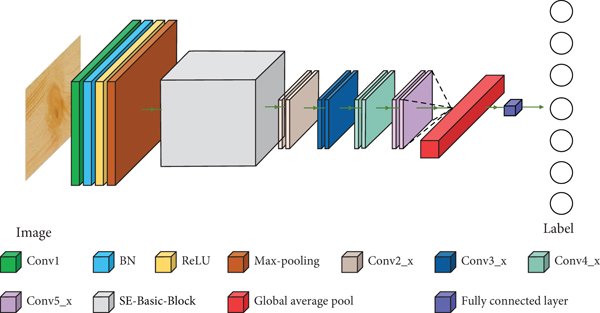

In [ ]:
import torchvision

model_frozen = torchvision.models.resnet18(pretrained= True)


In [ ]:
class NormalizeInput(nn.Module):
  def __init__(self, baseModel):
    """
    baseModel: the original ResNet model that needs to have its inputs preprocessed
    """
    super(NormalizeInput, self).__init__()
    self.baseModel = baseModel
    self.mean = nn.Parameter(torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1), requires_grad = False)
    self.std = nn.Parameter(torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1), requires_grad = False)

  def forward(self, input):
    input = ( input - self.mean) / self.std
    return self.baseModel(input)

In [ ]:
model_frozen = NormalizeInput(model_frozen)

In [ ]:
_ = model_frozen.to(device)

In [ ]:
def print_net_parameters(model_frozen):
    for name, para in model_frozen.named_parameters():
        print("-"*20)
        print(f"name: {name}")
        print("values: ")
        #print(para)

print_net_parameters(model_frozen)

In [ ]:
#all frozen
for p in model_frozen.parameters():
  p.requires_grad = False

In [ ]:
model_frozen

In [ ]:
model_frozen.fc = nn.Linear(model_frozen.fc.in_features, 10) #by difault the requires grad is True

In [ ]:
for name, param in model_frozen.named_parameters():
    if 'layer1' in name:
      param.requires_grad = True


In [ ]:
for name, p in model_frozen.named_parameters():
  if p.requires_grad :
    print("-"*20)
    print(f"name: {name}")

In [ ]:
writer = SummaryWriter('runs/frozen_model')

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from torch import  optim
from tqdm import tqdm

non_frozen_parameters = [p for p in model_frozen.parameters() if p.requires_grad]
optimizer = optim.Adam(non_frozen_parameters)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.1)
n_epochs = 15
criterion = nn.CrossEntropyLoss()
lrs = []

##
hty_val = dict()
hty_val['val_loss']= list()
hty_val['val_acc']= list()

##
hty_train = dict()
hty_train['train_loss']= list()
hty_train['train_acc']= list()

for epoch in range(1, n_epochs + 1):
  train(model_frozen, optimizer, epoch, "/content/frozen_ck.pt")
  validation(model_frozen, epoch)
  scheduler.step()


evaluation two models

In [ ]:
import shutil
import os

#make folders paths
test_path = "/content/persian_traffic_sign/PTSD_Recognition/PTSD_Recognition/test"
for i in range(10):
  os.mkdir(os.path.join(test_path + '/' + str(i) + '_' + labels_map[i]))


In [ ]:
import pandas as pd

labels = pd.read_csv("/content/persian_traffic_sign/testset_CSV.csv")

In [ ]:
import shutil

for image in range(2421):
  if labels.iloc()[image][1] in labels_map.values():
    for i in range(10):
      if labels_map[i] == labels.iloc()[image][1]:
        value = i
    shutil.move(test_path +'/PTSD_'+ labels.iloc()[image][0] , test_path + '/' + str(value)+'_'+ labels.iloc()[image][1])

In [ ]:
!rm -rf /content/persian_traffic_sign/PTSD_Recognition/PTSD_Recognition/test/*.jpg

In [ ]:
test_transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize(mean, std),
     transforms.Resize((200, 200))
])

test_dataset = datasets.ImageFolder(test_path, transform= test_transform)


In [ ]:
testloader = DataLoader(test_dataset, batch_size= B, shuffle= True)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


_ = model_frozen.to(device)
# Set the model to evaluation mode
model.eval()

# Initialize empty lists to store predicted and true labels
predicted_labels = []
true_labels = []

# Iterate over the test dataset
with torch.no_grad():
    for images, labels in testloader:  # Assuming you have a DataLoader for your test dataset
        # Forward pass to get the predicted logits
        images.to(device)
        input_tensor = images.type(torch.cuda.FloatTensor)
        outputs = model(image)
        # Apply a softmax function to convert logits to probabilities
        probabilities = nn.functional.softmax(outputs, dim=1)

        # Get the predicted labels by selecting the class with the highest probability
        _, predicted = torch.max(probabilities, 1)

        # Append the predicted and true labels to the respective lists
        predicted_labels.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


RuntimeError: ignored

In [ ]:
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print("acc:", accuracy, "\nprecision:", precision,"\nrecall:", recall,"\nf1:", f1)

acc: 0.3342857142857143 
precision: 0.4567278915463927 
recall: 0.3342857142857143 
f1: 0.2598261070049875


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


metric

feature visualizing

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms, utils
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
from PIL import Image
import json
%matplotlib inline

In [ ]:
transform_visualize = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor()
    #transforms.Normalize()
])

In [ ]:
image = Image.open("/content/persian_traffic_sign/PTSD_Recognition/PTSD_Recognition/test/3_Cycle crossing/PTSD_00158.jpg")
plt.imshow(image)

In [ ]:
model_children = list(model.children())

In [ ]:
model_children

In [ ]:
len(model_children)

In [ ]:
print(type(model_children[0][5]))

In [ ]:
# Create empty lists to store the weights and convolutional layers
model_weights = []
conv_layers = []

# Get all the model modules as a list
model_modules = list(model.modules())

# Counter to keep track of the convolutional layers
counter = 0

# Iterate over the modules and collect the convolutional layers and their weights
for module in model_modules:
    if isinstance(module, nn.Conv2d):
        counter += 1
        model_weights.append(module.weight)
        conv_layers.append(module)

# Print the total number of convolutional layers
print(f"Total convolutional layers: {counter}")

# Print the list of convolutional layers
print(conv_layers)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
from torchvision.transforms import ToPILImage

# Convert the tensor to a PIL image
to_pil = ToPILImage()
pil_image = to_pil(image)

# Apply the transformation on the PIL image
transformed_image = transform_visualize(pil_image)

# Convert the transformed image back to a tensor
transformed_tensor = torch.tensor(transformed_image)

print(f"Image shape before: {image.shape}")
print(f"Image shape after: {transformed_tensor.shape}")

transformed_tensor = transformed_tensor.unsqueeze(0).to(device)

In [ ]:
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

In [ ]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

In [ ]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')